In [1]:
from functools import partial
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from tqdm.auto import tqdm

In [2]:
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

diamond_df = pd.read_csv('diamonds.csv')
diamond_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
diamond_df.shape

(53940, 10)

In [4]:
diamond_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [5]:
diamond_df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [6]:
diamond_df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

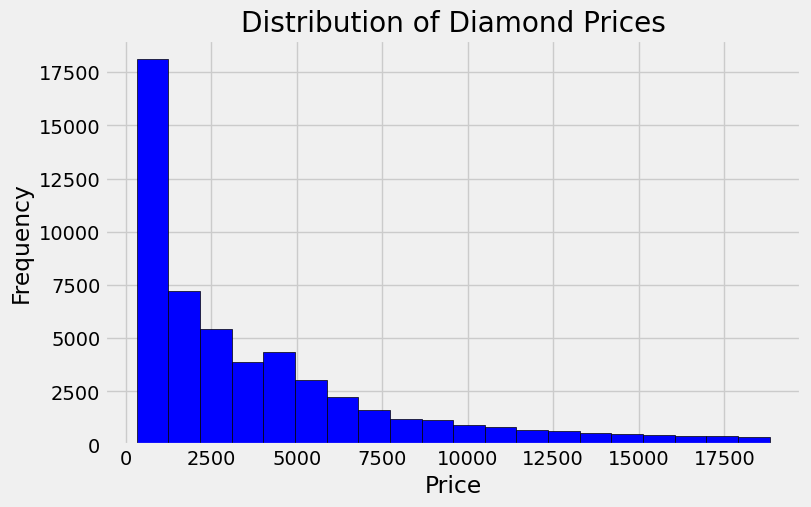

In [7]:
plt.figure(figsize=(8,5))
plt.hist(diamond_df['price'], bins=20, color='b', edgecolor='k');
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Diamond Prices')
plt.show()

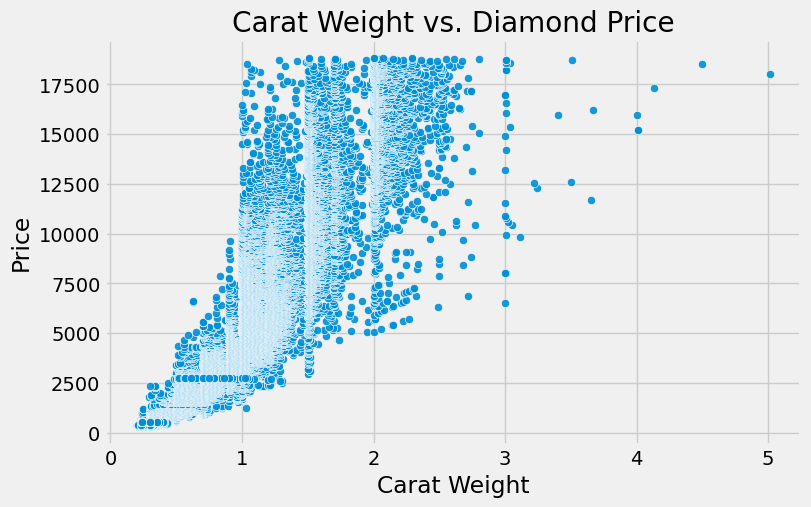

In [8]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='carat', y='price', data=diamond_df, alpha=0.9)
plt.xlabel('Carat Weight')
plt.ylabel('Price')
plt.title('Carat Weight vs. Diamond Price')
plt.show()

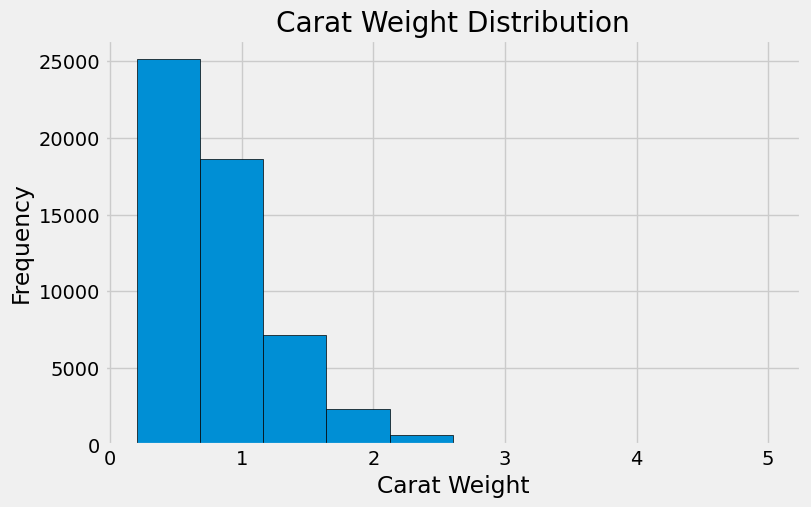

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(diamond_df['carat'], bins=10, edgecolor='k')
plt.xlabel('Carat Weight')
plt.ylabel('Frequency')
plt.title('Carat Weight Distribution')
plt.show()

In [10]:
X = diamond_df.drop(['price'], axis=1)
y = diamond_df['price']

# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape)

(43152, 9) (10788, 9)


In [11]:
label_encoder = LabelEncoder()

X_train['cut'] = label_encoder.fit_transform(X_train['cut'])
X_test['cut'] = label_encoder.transform(X_test['cut'])

X_train['color'] = label_encoder.fit_transform(X_train['color'])
X_test['color'] = label_encoder.transform(X_test['color'])

X_train['clarity'] = label_encoder.fit_transform(X_train['clarity'])
X_test['clarity'] = label_encoder.transform(X_test['clarity'])

In [12]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)


In [13]:
from itertools import product

ModelType = type[KNeighborsRegressor] | type[LinearRegression] | type[Ridge] | type[Lasso] | type[DecisionTreeRegressor] \
        | type[RandomForestRegressor] | type[SVR] | type[AdaBoostRegressor] | type[GradientBoostingRegressor]

dict_list_args:dict[ModelType, list[dict]] = {
        KNeighborsRegressor:[dict(n_neighbors=n, weights="distance", p=p) for n,p in product([5, 10, 20, 40, 80], [1,2,3])],
        LinearRegression:[dict()],
        Ridge:[dict(alpha=10**alpha) for alpha in range(-5, 3)],
        Lasso:[dict(alpha=10**alpha) for alpha in range(-8, 1)],
        DecisionTreeRegressor:[dict(min_samples_leaf=min_samples_leaf) for min_samples_leaf in range(1, 5)],
        RandomForestRegressor:[dict(n_estimators=n_estimators) for n_estimators in [10, 25, 50, 100]],
        SVR:[dict(C=C, kernel=kernel) for C, kernel in product(np.linspace(0.1, 1., 4), ['linear', 'rbf', 'sigmoid'])],
        AdaBoostRegressor:[dict(estimator=estimator, n_estimators=100) for estimator in [None, SVR]],
        GradientBoostingRegressor:[dict(learning_rate=learning_rate) for learning_rate in [1e-3, 1e-2, 1e-1]]
        }

In [14]:
results:dict[ModelType, dict] = {}
for model_cls, args_list in tqdm(dict_list_args.items()):
    
    best_r2 = best_mae = best_rmse = float("inf")
    best_args = None
    best_model = None
    for args in (pbar:=tqdm(args_list, leave=False)):
        try:
            model = model_cls(random_state=42, **args)
        except TypeError:
            model = model_cls(**args)
        model.fit(X=X_train_scaled, y=y_train)
        
        y_pred = model.predict(X_test_scaled)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        
        pbar.desc = f"{args}: mae:{mae:.2f}, rmse:{rmse:.2f}, r2:{r2:.2f}"
        
        if rmse <= best_rmse:
            best_rmse = rmse
            best_mae = mae
            best_r2 = r2
            best_args = args
            best_model = model
    
    results[model_cls] = dict(best_rmse=best_rmse, best_mae=best_mae, best_r2=best_r2, best_args=best_args, best_model=best_model)
        
    print(f"""{model_cls.__name__} has best fit when {best_args}, and rmse:{best_rmse:.2f}, mae:{best_mae:.2f}, r2:{best_r2:.2f}""")

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

KNeighborsRegressor has best fit when {'n_neighbors': 5, 'weights': 'distance', 'p': 1}, and rmse:719.65, mae:351.57, r2:0.97


  0%|          | 0/1 [00:00<?, ?it/s]

LinearRegression has best fit when {}, and rmse:1337.92, mae:859.18, r2:0.89


  0%|          | 0/8 [00:00<?, ?it/s]

Ridge has best fit when {'alpha': 1e-05}, and rmse:1337.92, mae:859.18, r2:0.89


  0%|          | 0/9 [00:00<?, ?it/s]

Lasso has best fit when {'alpha': 1e-08}, and rmse:1337.92, mae:859.18, r2:0.89


  0%|          | 0/4 [00:00<?, ?it/s]

DecisionTreeRegressor has best fit when {'min_samples_leaf': 4}, and rmse:672.05, mae:329.47, r2:0.97


  0%|          | 0/4 [00:00<?, ?it/s]

RandomForestRegressor has best fit when {'n_estimators': 100}, and rmse:541.12, mae:266.42, r2:0.98


  0%|          | 0/12 [00:00<?, ?it/s]